In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation, Bidirectional, GRU
import datetime
import os
from sklearn.preprocessing import MinMaxScaler

## 1. 데이터 전처리

In [9]:
# 현재 경로의 csv파일 읽어와서 days수 만큼 c, v값 합치기
folder = os.getcwd()
files = os.listdir(folder)
files = [x for x in files if x.find("bitcoin_2019") != -1]

# 학습시킬 데이터의 일 수. 필요한 만큼 조절하기
days = 78
print(files[-days:])
df = pd.read_csv(files[0]).loc[:][['c', 'v']]
df_time = pd.read_csv(files[0]).loc[:]['t']
for f in files[-days:]:
    tmp = pd.read_csv(f).loc[:][['c', 'v']]
    df = df.append(tmp, ignore_index=True)
    tmp_time = pd.read_csv(f).loc[:]['t']
    df_time = df_time.append(tmp_time, ignore_index=True)

df = pd.DataFrame(df)
df_time = pd.DataFrame(df_time)
print(df.shape, df_time.shape)
df.tail()

['bitcoin_20190601.csv', 'bitcoin_20190602.csv', 'bitcoin_20190603.csv', 'bitcoin_20190604.csv', 'bitcoin_20190605.csv', 'bitcoin_20190606.csv', 'bitcoin_20190607.csv', 'bitcoin_20190608.csv', 'bitcoin_20190609.csv', 'bitcoin_20190610.csv', 'bitcoin_20190611.csv', 'bitcoin_20190612.csv', 'bitcoin_20190613.csv', 'bitcoin_20190614.csv', 'bitcoin_20190615.csv', 'bitcoin_20190616.csv', 'bitcoin_20190617.csv', 'bitcoin_20190618.csv', 'bitcoin_20190619.csv', 'bitcoin_20190620.csv', 'bitcoin_20190621.csv', 'bitcoin_20190622.csv', 'bitcoin_20190623.csv', 'bitcoin_20190624.csv', 'bitcoin_20190625.csv', 'bitcoin_20190626.csv', 'bitcoin_20190627.csv', 'bitcoin_20190628.csv', 'bitcoin_20190629.csv', 'bitcoin_20190630.csv', 'bitcoin_20190701.csv', 'bitcoin_20190702.csv', 'bitcoin_20190703.csv', 'bitcoin_20190704.csv', 'bitcoin_20190705.csv', 'bitcoin_20190706.csv', 'bitcoin_20190707.csv', 'bitcoin_20190708.csv', 'bitcoin_20190709.csv', 'bitcoin_20190710.csv', 'bitcoin_20190711.csv', 'bitcoin_201907

,c,v
22747,12544000.0,0.000000
22748,12563000.0,0.000000
22749,12549000.0,0.160203
22750,12543000.0,0.000000
22751,12543000.0,0.000000


In [10]:
# 'bitcoin_20190817.csv' 데이터 빼주기
df = df[:len(df)-288]
df.shape

(22464, 2)

In [11]:
# df_truth는 minmaxscale하기 전 값. 마지막에서 수익 계산을 하기 위함.
df_truth = df.copy()
df_truth = df_truth['c'].values
df_truth = df_truth[-2215:]
print(df_truth)

[12041000. 12041000. 12041000. ... 11215000. 11215000. 11215000.]


In [12]:
# data scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df['c'] = scaler.fit_transform(df[['c']])
print(df.shape, df_truth.shape)

# NaN 체크
print(df.isnull().sum())

(22464, 2) (2215,)
c    0
v    0
dtype: int64


In [13]:
# 지수이동평균선(EMA) feature로 추가하기
import talib

df["ema12"] = talib.EMA(df['c'],6)

dataset = df.dropna(axis=0)
dataset=dataset.reset_index(drop=True)
print(dataset.shape)
dataset.head()

(22459, 3)


,c,v,ema12
0,0.173699,0.0,0.174664
1,0.177823,0.0,0.175567
2,0.177823,0.0,0.176211
3,0.175191,0.0,0.175920
4,0.179753,0.0,0.177015


In [51]:
# nan값이 있다면 지워주고, 이름은 dataset변수에 따로 저장.
dataset = df.dropna(axis=0)
print(dataset.shape)
dataset.head()

(22459, 3)


,c,v,ema12
5,0.173699,0.0,0.174664
6,0.177823,0.0,0.175567
7,0.177823,0.0,0.176211
8,0.175191,0.0,0.175920
9,0.179753,0.0,0.177015


In [52]:
# nan이 있어서 삭제되었을 경우 index 재설정.
print(np.shape(dataset))
dataset=dataset.reset_index(drop=True)
dataset[:5]

(22459, 3)


,c,v,ema12
0,0.173699,0.0,0.174664
1,0.177823,0.0,0.175567
2,0.177823,0.0,0.176211
3,0.175191,0.0,0.175920
4,0.179753,0.0,0.177015


In [14]:
# window 만들기
# NPS: 과거데이터, NFS: 예측할 미래 데이터

NPS = 288    # 288*5분 = 24시간 
NFS = 24    # 24*5분 = 2시간
sequence_length = NPS + NFS
feature_num = len(dataset.columns)

windows = []
for idx in range(len(dataset) - sequence_length):
    windows.append(dataset[idx: idx + sequence_length][:].values)

windows = np.asarray(windows).astype('float32')
print(np.shape(windows))
windows[:2]

(22147, 312, 3)


array([[[0.17369945, 0.        , 0.17466444],
        [0.17782262, 0.        , 0.17556678],
        [0.17782262, 0.        , 0.1762113 ],
        ...,
        [0.1822967 , 0.        , 0.179326  ],
        [0.18510395, 0.        , 0.18097684],
        [0.18659532, 0.        , 0.18258213]],

       [[0.17782262, 0.        , 0.17556678],
        [0.17782262, 0.        , 0.1762113 ],
        [0.1751908 , 0.        , 0.17591973],
        ...,
        [0.18510395, 0.        , 0.18097684],
        [0.18659532, 0.        , 0.18258213],
        [0.18510395, 0.0995    , 0.18330264]]], dtype=float32)

In [15]:
# train data와 test data로 나누기

row = round(len(windows) * 0.9)
train = windows[:row, :, :]

# training data는 NPS개 이므로 sequence_length-NFS만큼 가져오기
x_train = train[:, :NPS, :]
y_train = train[:, NPS:, 0]

x_test = windows[row:, :NPS, :]
y_test = windows[row:, NPS:, 0]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(19932, 288, 3) (2215, 288, 3)
(19932, 24) (2215, 24)


## 2. 딥러닝 모델 정의

In [10]:
# LSTM input은 3차원

model = Sequential()
model.add(GRU(NPS, input_shape=(NPS,feature_num)))
model.add(Dense(NFS, activation="relu"))
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 288)               253152    
_________________________________________________________________
dense (Dense)                (None, 24)                6936      
Total params: 260,088
Trainable params: 260,088
Non-trainable params: 0
_________________________________________________________________
None


## 3. 학습

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint 저장할 폴더 설정
checkpoint_path = "checkpoint_GRU_ma"
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path)

# 파일 이름에 에포크 번호를 포함시킵니다(`str.format` 포맷)
checkpoint_name = checkpoint_path + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# period 번째 에포크마다 가중치를 저장.
cp_callback = ModelCheckpoint(checkpoint_name, verbose=1, save_weights_only=True, save_best_only=True, period=5)

print(x_train.shape)

# epochs 수 조절해서 학습시키기
model.fit(x_train, y_train,
         callbacks = [cp_callback],
         validation_data=(x_test, y_test),
         batch_size=36,
         epochs=5,
         verbose=1)

# 모델 저장
model.save('model_gru_ma.h5')
model.evaluate(x_test, y_test)

W0819 17:11:35.947428 17960 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


(19932, 288, 3)
Train on 19932 samples, validate on 2215 samples
Epoch 1/5
19932/19932 [==============================] - 308s 15ms/sample - loss: 4.1766e-04 - mae: 0.0129 - val_loss: 4.5380e-04 - val_mae: 0.0140
Epoch 2/5
19932/19932 [==============================] - 276s 14ms/sample - loss: 4.1365e-04 - mae: 0.0127 - val_loss: 5.0109e-04 - val_mae: 0.0162
Epoch 3/5
19932/19932 [==============================] - 274s 14ms/sample - loss: 4.1276e-04 - mae: 0.0127 - val_loss: 4.8490e-04 - val_mae: 0.0147
Epoch 4/5
19932/19932 [==============================] - 272s 14ms/sample - loss: 4.0879e-04 - mae: 0.0127 - val_loss: 5.6573e-04 - val_mae: 0.0167
Epoch 5/5
19908/19932 [============================>.] - ETA: 0s - loss: 4.0479e-04 - mae: 0.0127
Epoch 00005: val_loss improved from inf to 0.00046, saving model to checkpoint_GRU_ma/cp-0005.ckpt
2215/2215 [==============================] - 15s 7ms/sample - loss: 4.5912e-04 - mae: 0.0137


[0.0004591227225006955, 0.013736631]

## 4. 테스트

In [74]:
# pre-trained model이 저장되어 있다면 불러오기
from tensorflow.keras.models import load_model
model = load_model('model_gru_ma.h5')

In [75]:
# 학습 모델 이어서 학습시 epochs 조절해서 추가로 학습하기
# 또는 정상적으로 불러와졌는지 1에폭만 돌려서 loss값 보고 확인하기

model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         batch_size=36,
         epochs=1,
         verbose=1)

Train on 19932 samples, validate on 2215 samples
19932/19932 [==============================] - 307s 15ms/sample - loss: 4.0311e-04 - mae: 0.0126 - val_loss: 4.5312e-04 - val_mae: 0.0136


In [76]:
# x_test데이터로 예측하기
import matplotlib.pyplot as plt
%matplotlib inline

pred = model.predict(x_test)
pred.shape

(2215, 24)

In [77]:
import math
from sklearn.metrics import mean_squared_error

In [79]:
# make prediction

testPredict = scaler.inverse_transform(pred)
testY = scaler.inverse_transform(y_test)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
#testScore = math.sqrt(mean_squared_error(y_test, pred))

print('Train Score: %.2f RMSE' % testScore)

Train Score: 121323.44 RMSE


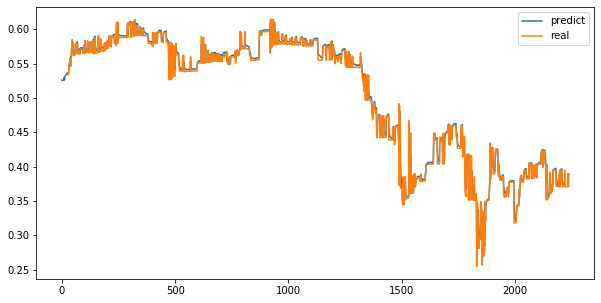

In [84]:
# 위에서 예측한 pred 값과 실제 값인 y_test값이 얼마나 일치하는지 그래프로 확인
plt.figure(figsize=(10,5))
plt.plot(pred[:,-1], label="predict")
plt.plot(np.arange(NFS, len(y_test[:,-1])+NFS) ,y_test[:,-1], label="real")

# 아래 코드 주석풀고 xlim을 조절하면서 확대해보기
#plt.xlim(1800,2200)
#plt.ylim(0.2, 0.5)
plt.legend()


## 5. 시각화

In [30]:
# shape 확인
print(df_truth.shape, y_test.shape)

(2215,) (2215, 24)


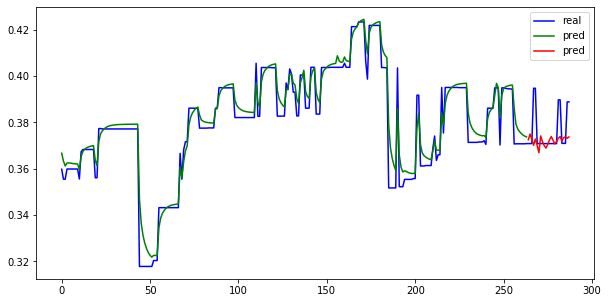

In [46]:
# 파란선: y_test(실제 값)
# 초록선: test데이터에 있는 날짜 예측한 값
# 빨간선: test데이터에 없는 날짜 예측값

y = y_test[-NPS:,-1].reshape(-1,1)
p = pred[-(NPS-NFS):,-1].reshape(-1,1)
plt.figure(figsize=(10,5))
plt.plot(y, color='b' ,label='real')
plt.plot(p, color='g', label = 'pred')
plt.plot(np.arange(NPS-NFS, NPS), pred[-1], color='r', label='pred')
plt.legend()
plt.show()

In [47]:
# 이동평균선 계산 함수
# data: NFS길이의 배열, ema_len: 평균 계산 길이, init: EMA 첫 번째 값 
def cal_EMA(data, ema_len, init):
    EMA = [init]
    for i in range(1,len(data)):
        EP = 2 / (ema_len + 1)
        EMA.append((data[i] * EP) + (EMA[i-1] * (1-EP)))
    return EMA

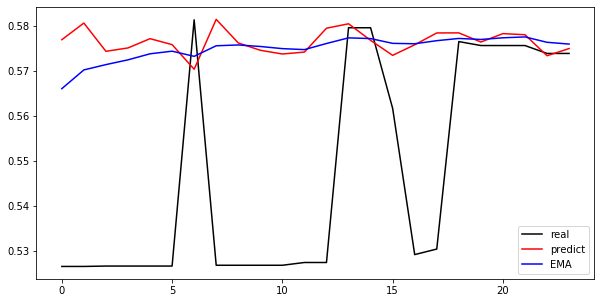

In [71]:
# 검은선: y_test(실제 값)
# 빨간선: pred(딥러닝 모델이 예측한 값)
# 파란선: 이동평균선(ema(6))
ema_len = 6
pred_time = 448
pred_gh = pred[pred_time:pred_time+NFS][-1]

plt.figure(figsize=(10,5))
plt.plot(y_test[pred_time:pred_time+NFS][-1], color='k' ,label='real')
plt.plot(pred_gh, color='r', label = 'predict')
EMA = cal_EMA(pred_gh, 6, 0.566,)
plt.plot(EMA, color='b', label='EMA')
plt.legend()
plt.show()

## 매수 매도 타이밍 계산

In [69]:
# 예측 데이터로 찾은 매수매도 타이밍을 실제 데이터에 적용했을 때 얻는 수익
# prices는 NPS길이의 배열

def max_Profit(prices,time):
    n = len(prices)
    max_profit = 0
    min_price = prices[0]
    
    sell_idx = 0
    buy_idx = 0
    
    for i in range(n-1):
        for j in range(i+1, n):
            profit = prices[j] - prices[i]
            if profit > max_profit:
                max_profit = profit
                sell_idx = j
                buy_idx = i
    
    
    #print(df_truth[buy_idx+time], df_truth[sell_idx+time])
    max_profit = df_truth[sell_idx+time-1] - df_truth[buy_idx+time-1]
    return max_profit, buy_idx, sell_idx

# pred_gh 와 EMA 총 수익 결과 비교해보기
profit, buy_time, sell_time = max_Profit(pred_gh,pred_time)
#profit, buy_time, sell_time = max_Profit(EMA,pred_time)
print(profit, buy_time, sell_time)

-49500.0 6 7


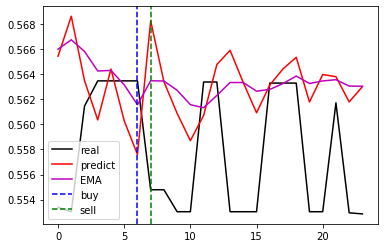

In [70]:
plt.plot(y_test[pred_time:pred_time+24][-1], color='k' ,label='real')
plt.plot(pred_gh, color='r', label = 'predict')
plt.plot(EMA, color='m', label='EMA')
plt.axvline(x=buy_time, color='b', linestyle='--', label='buy')
plt.axvline(x=sell_time, color='g', linestyle='--', label='sell')
plt.legend()
plt.show()

## EMA를 이용한 2215개(7일 16시간 35분) 예측의 총 수익

In [71]:
total_profit = 0
total_loss = 0
cnt = 0
for i in range(0,pred.shape[0]-24,24):
    cnt += 1
    EMA = cal_EMA(pred[i:i+24][-1], 6, 0.55,)
    profit, _, _ = max_Profit(EMA,i)
    print(cnt, i, profit)
    if profit >= 0 :
        total_profit += profit
    else:
        total_loss += profit

revenue = total_profit + total_loss

print("이익:", total_profit)
print("손실:", total_loss)
print("총수익(이익-손실):", total_profit+total_loss)

1 0 20000.0
2 24 500.0
3 48 36000.0
4 72 100000.0
5 96 89500.0
6 120 16000.0
7 144 2500.0
8 168 125000.0
9 192 27000.0
10 216 70000.0
11 240 -500.0
12 264 0.0
13 288 -19500.0
14 312 2000.0
15 336 -51000.0
16 360 -20000.0
17 384 90500.0
18 408 -2000.0
19 432 -389000.0
20 456 20500.0
21 480 -219500.0
22 504 -55000.0
23 528 2000.0
24 552 0.0
25 576 4500.0
26 600 5500.0
27 624 7000.0
28 648 56500.0
29 672 59500.0
30 696 -85000.0
31 720 0.0
32 744 102000.0
33 768 -132000.0
34 792 -97000.0
35 816 5000.0
36 840 204500.0
37 864 0.0
38 888 -115500.0
39 912 -82500.0
40 936 1500.0
41 960 4000.0
42 984 -45000.0
43 1008 -55500.0
44 1032 -14000.0
45 1056 45000.0
46 1080 48000.0
47 1104 -166000.0
48 1128 -10500.0
49 1152 8000.0
50 1176 -49500.0
51 1200 39500.0
52 1224 -9000.0
53 1248 -500.0
54 1272 1500.0
55 1296 -119500.0
56 1320 -3000.0
57 1344 -280000.0
58 1368 0.0
59 1392 0.0
60 1416 0.0
61 1440 -107500.0
62 1464 -101000.0
63 1488 37500.0
64 1512 69000.0
65 1536 -27000.0
66 1560 134500.0
67 1584 

In [ ]:
'''
에러
https://github.com/keras-team/keras/issues/11749
The Incompatible shapes error is always [batchsize*final_layer_units] vs. [batchsize]

https://github.com/kuza55/keras-extras/issues/7


참고하기
https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

LSTM input, output 설명
https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e


GRU
https://www.programcreek.com/python/example/97114/keras.layers.recurrent.GRU

'''